<div>
<img src="figures/svtLogo.png"/>
</div>

<center><h1>Mathematical Optimization for Engineers</h1></center>
<center><h2>Bonus exercise 2</h2></center>

In Lecture 10, you learn about methods for deterministic global optimization of non-linear *non-convex* functions. One of these methods is the Branch-and-Bound method where the feasible set is iteratively branched and pruned, based on a check against estimated upper and lower bounds on the optimal solution. In this exercise, you will implement the bounding procedure and apply it in a branch and bound algorithm for problems of the following class:

\begin{align} \label{eq:optprob}
  \min_{\boldsymbol{x}\in\mathbb{R}^n}\;& \boldsymbol{x}^T\boldsymbol{H}\boldsymbol{x} + \boldsymbol{c}^T\boldsymbol{x}\\
  \mathrm{s.t.}\; & \boldsymbol{x}^T\boldsymbol{Q}_i\boldsymbol{x} + \boldsymbol{a}_i\boldsymbol{x} = b_i\; \forall\; i\in\, \{1,...,m\}\\
  & \boldsymbol{x}^L \leq \boldsymbol{x} \leq \boldsymbol{x}^U
\end{align}

with $n,m\in\mathbb{N}$, $m<n$, a symmetric, positive semidefinite matrix $\boldsymbol{H}\in\mathbb{R}^{n\times n}$, symmetric indefinite matrices $\boldsymbol{Q}_i\in\mathbb{R}^{n\times n}\,\forall i\in \{1,...,m\}$, $\boldsymbol{c}\in\mathbb{R}^n$, $\boldsymbol{A}\in\mathbb{R}^{m\times n}$ with row vectors $\boldsymbol{a}_i$, and $\boldsymbol{b}\in\mathbb{R}^m$.
The above problem is a nonconvex optimization problem with the possibility of suboptimal local minima.

Example 1 fits into this formulation: 
\begin{align}
  \min_{\boldsymbol{x}\in \mathbb{R}^3}\;& x_1 + x_2 + x_3^2\\
  \mathrm{s.t.}\; & x_1x_2 + x_3 = 8\\
  &x_2x_3 = 15 \\
  & 0 \leq x_1, x_2, x_3 \leq 10
\end{align}

The terms $x_1x_2$ and $x_2x_3$, which are responsible for the non-convexity of the model, are called *bilinear* terms.
In example 1, the matrices and vectors in the general problem definition would be
\begin{align}
  \begin{array}{ccc}
  \boldsymbol{c} = \left[1,1,0\right]^T,&\boldsymbol{b} = \left[8,15\right]^T, &\boldsymbol{A} = \left[\begin{array}{ccc}0&0&1\\0&0&0\end{array}\right]\\\boldsymbol{H} = \left[\begin{array}{ccc}0&0&0\\0&0&0\\0&0&1\end{array}\right]\,&
  \boldsymbol{Q}_1 = \left[\begin{array}{ccc}0&0.5&0\\0.5&0&0\\0&0&0\end{array}\right],\,&
  \boldsymbol{Q}_2 = \left[\begin{array}{ccc}0&0&0\\0&0&0.5\\0&0.5&0\end{array}\right]
\end{array}
\end{align}

### The Algorithm
In order to get a lower bound on the objective value of the nonconvex optimization problem, we need to construct a *convex relaxation* and solve it to global optimality.
One widely used relaxation of the *bilinear* terms $x_ix_j$ are the so-called *McCormick Envelopes*.
The relaxation works as follows:
each term $x_ix_j$ is replaced by an auxiliary variable $w_{ij}$.
Then, the following constraints for $w_{ij}$ are defined:

\begin{align}
  w_{ij} &\geq x_i^Lx_j + x_ix_j^L - x_i^Lx_j^L\label{eq:mcccormick1}\\
  w_{ij} &\geq x_i^Ux_j + x_ix_j^U -x_i^Ux_j^U\label{eq:mcccormick2}\\
  w_{ij} &\leq x_i^Ux_j+x_ix_j^L -x_i^Ux_j^L\label{eq:mcccormick3}\\
  w_{ij} &\leq x_i^Lx_j+x_ix_j^U -x_i^Lx_j^U\label{eq:mcccormick4}
\end{align}

These constraints are added to the original optimization problem, and the bilinear terms are replaced with the variables $w_{ij}$.
The resulting convex QP (quadratic objective \& linear constraints) is solved using standard methods, yielding a lower bound on the objective value.


Now, complete the implementation below:

In [2]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

# to construct relaxations for lower-bounding problem
from math import inf, sin, cos, sqrt, nan, isnan

# for branching
import copy

import sys
!{sys.executable} -m pip install ipympl

### Visualization of relaxation for quadratic problem

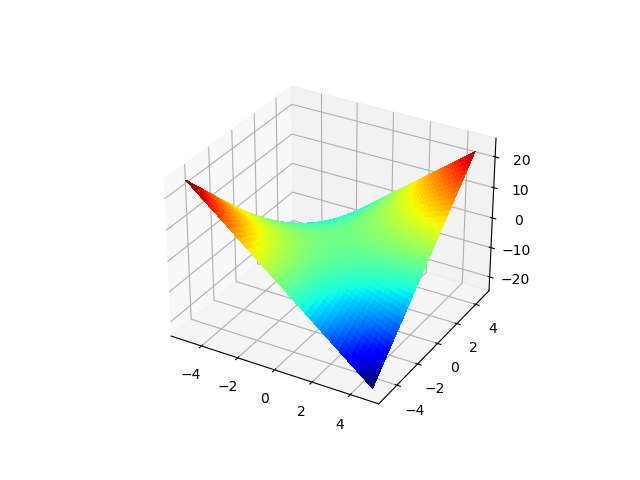

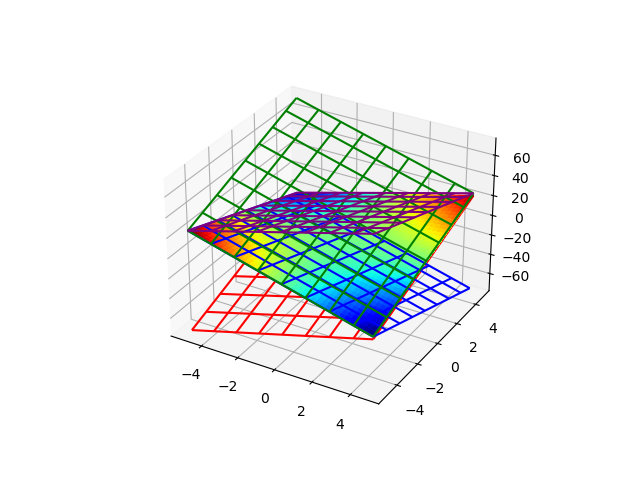

In [3]:
%matplotlib ipympl
# uncomment the first line to have interactive plots

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X_l = -5
X_u = +5
Y_l = -5
Y_u = +5
# Make data.
X = np.arange(X_l, X_u, 0.25)
Y = np.arange(Y_l, Y_u, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (X * Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)


# Envelopes
Z1 = (X_l * Y + X * Y_l - X_l * Y_l)
Z2 = (X_u * Y + X * Y_u - X_u * Y_u)
Z3 = (X_u * Y + X * Y_l - X_u * Y_l)
Z4 = (X_l * Y + X * Y_u - X_l * Y_u)

fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax1.plot_surface(X, Y, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)
surf = ax1.plot_wireframe(X, Y, Z1, rstride=5, cstride=5, color='blue')
surf = ax1.plot_wireframe(X, Y, Z2, rstride=5, cstride=5, color='red')
surf = ax1.plot_wireframe(X, Y, Z3, rstride=5, cstride=5, color='green')
surf = ax1.plot_wireframe(X, Y, Z4, rstride=5, cstride=5, color='purple')


In [34]:
def convex_bounds(n,m,c,H,Q,A,b,lb,ub, verbose=False):
    #   70 points
    #   n is the number of optimization variables
    #   m is the number of eq constraints
    #   H = positive, semidefinite matrix from objetcive function (n x n)
    #   Q is (mxn) x n 
    #   A is m x n
    #   b is RHS of non linear eq constraints (m x 1)
    #   c,lb,ub are vectors size (n x 1)
    
    def check_symmetric(a, rtol=1e-05, atol=1e-08):
        return np.allclose(a, a.T, rtol=rtol, atol=atol)    
    
    # initialize bounds
    fub = float("inf")
    flb = -float("inf")
    
    # Symmetry test
    #   Check all Qi matrices for symmetry 
    for i in range(m):
        Qi = Q[ i*n : (i+1)*n , :]
        if (not(check_symmetric(Qi))):
            print("Matrix Q{:d} not symmetric. Check input.".format(i+1))
            return fub, flb

    # Dimension test
    if (np.shape(Q)[0] != m*n or np.shape(Q)[1] != n):
        print("Matrix Q has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(b) != m):
        print("Vector b has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(c) != n):
        print("Vector c has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(lb) != n):
        print("Vector lb has incorrect dimensions. Check input.")
        return fub, flb
    
    if (len(ub) != n):
        print("Vector ub has incorrect dimensions. Check input.")
        return fub, flb
    
    if (np.shape(H)[0] != n or np.shape(H)[1] != n):
        print("Matrix H has incorrect dimensions. Check input.")
        return fub, flb 
    
    if (np.shape(A)[0] != m or np.shape(A)[1] != n):
        print("Matrix A has incorrect dimensions. Check input.")
        return fub, flb
    
    # Inspect matices Qi & generate auxilliary variables
    # The Matrix A will be appended with the entries that correspond to 
    # the auxiliary variables wij.
    #   If we do not check for already existing combinations, 
    #   then the same combination x_i.x_j might be treated as
    #   different aux vars in different constraints
    
    # counter variable (count) to know the number of bilinear terms
    count = 1
    combination_exists = 0
    # initialize w_combination to [-1,-1]
    w_combination = -1*np.ones((1,2))
    # initialize A_help (to be appended later to A)
    A_help = np.zeros((m,1))
    
    # you need to determine which bilinear terms exist and decide wether a combination x_i*x_j already exists
    # Each bilinear term may only be relaxed once.
    # Hint: Is there a difference between x1*x2 and x2*x1?
    # Do we need to consider all entries of Qi? -> We should only consider the top triangle

    # You need to consider all constraints
    # You need to check which bilinear terms are present in each constraint
    # the variables w_combination and A_help will be populated. 
    
    
    ### YOUR CODE HERE
    all_w = list(itertools.combinations(range(n), 2))

    A_help = np.zeros((m,len(all_w)))

    for w_i, w in enumerate(all_w):
        for i in range(2):
            Qi = Q[ i*n : (i+1)*n , :]
            Qi_plus = Qi + Qi.T
            A_help[i,w_i] += Qi_plus[w]

    unused_ws = np.where(np.sum(A_help,axis=0) == 0)[0]
    A_help = np.delete(A_help, unused_ws, 1)
    all_w = np.delete(np.array(all_w), unused_ws, 0)
    count = len(all_w)
    
    
    # append A_help to A
    if count>0:
        Aeq = np.hstack((A,A_help))
    else:
        Aeq = A
        
    # Create matrix B & b_ineq for inequality constraints
    # where B*x <= b_ineq
    
    ### YOUR CODE HERE
    B = np.zeros([4*count,n+count])
    b_ineq = np.zeros([4*count])

    for i, w in enumerate(all_w):
        w_i,w_j = w
        # constraint 1
        B[i*4,w_i] = lb[w_j]
        B[i*4,w_j] = lb[w_i]
        B[i*4,n+i] = -1
        b_ineq[i*4] = lb[w_j]*lb[w_i]

        # constraint 2
        B[i*4+1,w_i] = ub[w_j]
        B[i*4+1,w_j] = ub[w_i]
        B[i*4+1,n+i] = -1
        b_ineq[i*4+1] = ub[w_j]*ub[w_i]

        # constraint 3
        B[i*4+2,w_i] = -lb[w_j]
        B[i*4+2,w_j] = -ub[w_i]
        B[i*4+2,n+i] = 1
        b_ineq[i*4+2] = -lb[w_j]*ub[w_i]

        # constraint 4
        B[i*4+3,w_i] = -ub[w_j]
        B[i*4+3,w_j] = -lb[w_i]
        B[i*4+3,n+i] = 1
        b_ineq[i*4+3] = -ub[w_j]*lb[w_i]
        
    # Initialization of remaining components
    lb_relax = np.append(lb, float('-inf')*np.ones(count))
    ub_relax = np.append(ub, float('inf')*np.ones(count))
    
    
    H_relax = None
    c_relax = None

    # rest of H matrix and C vector must be filled with 0
    if count>0: 
        H_relax = np.hstack((H, np.zeros((n, count))))
        H_relax = np.vstack((H_relax, np.zeros((count, n + count))))
        c_relax = np.hstack((c, np.zeros(count)))
    else:
        H_relax = H
        c_relax = c
            
        
    x0 = (np.array(lb) + np.array(ub)) / 2
    x0 = np.concatenate([x0, np.ones(count)])
    
    def cvxRelax(x):
        return (np.dot(x.T, np.dot(H_relax, x))+ np.dot(c_relax, x))
    
    def jac(x):
        return (2*np.dot(x.T, H_relax) + c_relax)
    
    ineq_cons  = {'type':'ineq',
        'fun':lambda x: b_ineq - np.dot(B,x),
        'jac':lambda x: -B}
    
    eq_cons  = {'type':'eq',
        'fun':lambda x: b - np.dot(Aeq,x),
        'jac':lambda x: -Aeq}
    
    bounds = optimize.Bounds(lb_relax, ub_relax)
    
    opt = {'disp':verbose}
    # call optimization for relaxed problem 
    # HINTS:
    # res_lb = ...
    # method='SLSQP', jac=jac,constraints=[eq_cons, ineq_cons], options=opt
    
    ### YOUR CODE HERE
    vars_bounds = optimize.Bounds(lb, ub)
    res_lb = optimize.minimize(cvxRelax, x0, \
                     bounds = bounds, constraints=[eq_cons, ineq_cons], method='SLSQP',\
                     jac=jac,
                     options=opt)
    
    
    # the function value is in res_lb.fun
    return res_lb

convex_bounds(**example_1())

     fun: 8.649999999999999
     jac: array([1., 1., 3., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 0.65,  5.75,  1.5 ,  6.5 , 15.  ])

In [5]:
def solve_original_problem(n,m,c,H,Q,A,b,lb,ub, verbose=False):
    # 10 points
    def objective(x):
        return (np.dot(x.T, np.dot(H, x))+ np.dot(c, x))
    
    def eq_cons(x): 
        c = np.zeros(m)
        for i in range(m):
            Qi = Q[ i*n : (i+1)*n , :]
            c[i] = np.dot(x.T, np.dot(Qi, x)) + np.dot(A[i], x) - b[i]
        return c
    
    x0 = (np.array(lb) + np.array(ub)) / 2
    bounds = optimize.Bounds(lb, ub)
    opt = {'disp':verbose}
    my_equalities = optimize.NonlinearConstraint(eq_cons, np.zeros(m), np.zeros(m))

    res_ub = optimize.minimize(objective, x0, constraints=[my_equalities],
                            method='SLSQP',bounds=bounds, options=opt)
    # the function value is in res_ub.fun
    return res_ub


In [24]:
def stochastic_solver(n,m,c,H,Q,A,b,lb,ub, verbose=False):
    def objective(x):
        return (np.dot(x.T, np.dot(H, x))+ np.dot(c, x))
    
    
    x0 = np.array([0, 15/8, 8])
    
    xs = np.arange(0, 16/15, 0.0000001)[1:]
    y1s = (4 - np.sqrt(16 - 15 * xs))/xs
    z1s = np.sqrt(16 - 15 * xs) + 4
    y2s = (4 + np.sqrt(16 - 15 * xs))/xs
    z2s = 4 - np.sqrt(16 - 15 * xs)
    
    set1 = np.vstack([xs, y1s, z1s])
    set2 = np.vstack([xs, y2s, z2s])
    data_points = np.hstack([np.expand_dims(x0,-1), set1, set2])
    
    min_x = None
    min_obj = inf
    
    for x in data_points.T:
        objs = x[0] + x[1] + x[2]**2
        if objs < min_obj:
              min_obj = objs
              min_x = x
                  
    return min_obj, min_x
    
    
print(stochastic_solver(**example_1()))

(12.276949307688103, array([0.7760502 , 7.84469997, 1.91211902]))


### Example 1 (check on bounding procedure)

\begin{align}
  \min_{\boldsymbol{x}\in \mathbb{R}^3}\;& x_1 + x_2 + x_3^2\\
  \mathrm{s.t.}\; & x_1x_2 + x_3 = 8\\
  &x_2x_3 = 15 \\
  & 0 \leq x_1, x_2, x_3 \leq 10
\end{align}


#### Hint 
The value of the valid lower bound is 4.4 and for the upper bound 12.276. 

In [35]:
# problem definition
def example_1():
    output = {
        "n": 3,
        "m": 2,
        "c": [1, 1, 0],
        "b": [8,15],
        "A": np.zeros((2, 3)),
        "H": np.zeros((3, 3)),
        "lb": [0, 0, 0],
        "ub": [10, 10, 10],
    }
    output["A"][0, 2] = 1
    output["H"][2, 2] = 1

    Q1 = np.zeros((3,3))
    Q1[0,1] = 0.5
    Q1[1,0] = 0.5
    Q2 = np.zeros((3,3))
    Q2[2,1] = 0.5
    Q2[1,2] = 0.5
    output["Q"] = np.vstack((Q1, Q2))
    return output


f_lb = convex_bounds(**example_1())
print("Lower bound is: ", f_lb.fun)
print(f_lb)
print(solve_original_problem(**example_1()))

Lower bound is:  4.399999999999998
     fun: 4.399999999999998
     jac: array([1., 1., 3., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.65,  1.5 ,  1.5 ,  6.5 , 15.  ])
     fun: 12.276948967035986
     jac: array([1.        , 1.        , 3.82424796])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.77605158, 7.84467946, 1.91212393])


### Example 2 (check on bounding procedure)

\begin{align}
	\min_{\boldsymbol{x}\in \mathbb{R}^4}\;& x_1 + x_2 + x_3^2 + x_{4}^2\\
	\mathrm{s.t. \,}\; & x_1x_2 + x_{2}x_3 = 2\\
	&x_1x_2 + x_{4} = 3 \\
	&x_{1} + x_{2}x_{3} = 5 \\
	& 0 \leq x_1, x_3, x_4 \leq 10 \\
	& 0 \leq x_{2} \leq 4
\end{align}

#### Hint 
The value of the valid lower bound is 6.2 and 6.4 for the upper bound.

In [10]:
# define the optimization problem
# 20 points

# problem definition
def example_2():
    n = 4
    m = 3
    output = {
        "n": n,  # number of variables
        "m": m,  # number of constraints
        "c": [1, 1, 0, 0],
        "b": [2, 3, 5],
        "A": np.zeros((m, n)),
        "H": np.zeros((n, n)),
        "lb": [0, 0, 0, 0],
        "ub": [10, 4, 10, 10]
    }
    output["A"][1,3] = 1
    output["A"][2,0] = 1

    output["H"][2,2] = 1
    output["H"][3,3] = 1

    Q1 = np.zeros((n, n))
    Q1[0,1] = 0.5
    Q1[1,0] = 0.5
    Q1[1,2] = 0.5
    Q1[2,1] = 0.5
    Q2 = np.zeros((n, n))
    Q2[0,1] = 0.5
    Q2[1,0] = 0.5
    Q3 = np.zeros((n, n))
    Q3[1,2] = 0.5
    Q3[2,1] = 0.5
    output["Q"] = np.vstack((Q1, Q2, Q3))

    return output


f_lb = convex_bounds(**example_2())
print("Lower bound is: ", f_lb.fun)
f_ub = solve_original_problem(**example_2())
print("Upper bound is: ", f_ub.fun)

Lower bound is:  6.200000000000001
Upper bound is:  6.4


### Implementation of branch & bound algorithm
Use your implemented function of the lower bounding and upper bounding in a branch & bound algorithm. 
You can either adjust the algorithm of lab 10 or implement it yourself.
However, the required interface must be *branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub)*



In [67]:
def computeUpperBounds(nodes, **optimization_parameters):
    for iNode in nodes:
        if iNode["ubd"] == inf: 
            solUBD = solve_original_problem(**optimization_parameters, lb=iNode["lb"], ub=iNode["ub"])
            if solUBD.success:
                iNode["ubd"] = solUBD.fun
            else:
                iNode["ubd"] = nan
            
    return nodes

def computeLowerBounds(nodes, **optimization_parameters):
    for iNode in nodes:
        if iNode["lbd"] == -inf: 
            solLBD = convex_bounds(**optimization_parameters, lb=iNode["lb"], ub=iNode["ub"])
            if solLBD.success:
                iNode["lbd"] = solLBD.fun
            else:
                iNode["lbd"] = nan
            
    return nodes

def branching(nodes, globalLBD): 
    epsilonF = 0.001
    
    chosenNode = nodes[0]
    # choose node with lowest LBD 
    for iNode in nodes: 
        if iNode["lbd"] <= globalLBD + epsilonF:
            chosenNode = iNode
            break
    
    # branch on variable with largest variable bounds
    delta = np.array(chosenNode["ub"]) - np.array(iNode["lb"])
    indVariable = np.argmax(delta)
    
    # simply branch in the middle
    iNodeLeft = copy.deepcopy(chosenNode)
    iNodeLeft["ub"][indVariable] = (iNodeLeft["ub"][indVariable] + iNodeLeft["lb"][indVariable])/2
    iNodeLeft["lbd"] = - inf
    iNodeLeft["ubd"] = + inf

    
    iNodeRight = copy.deepcopy(chosenNode)
    iNodeRight["lb"][indVariable] = iNodeLeft["ub"][indVariable]
    iNodeRight["lbd"] = - inf
    iNodeRight["ubd"] = + inf

    
    # bookkeeping
    nodes.remove(chosenNode)
    nodes.append(iNodeLeft)
    nodes.append(iNodeRight)
       
    
    return nodes

def fathom(iNode, globalUBD):
    # fathom if true
    if iNode["lbd"] > globalUBD:
        return True
    else:
        return False

In [68]:
# Implementation of branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub) and other required functions.
def branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub, verbose=False):
    
    foundGlobalSolution = False
    epsilonF = 0.001 # absolute tolerance
    UBD = inf
    LBD = -inf
    nodes = []
    optimization_parameters = {
        'n': n,
        'm': m,
        'c': c,
        'H': H,
        'Q': Q,
        'A': A,
        'b': b,
        'verbose': verbose
    }

    # initial point
    x0 = (np.array(lb) + np.array(ub))/2
    
    bnds = []
    for i in range(0, len(lb)):
        bnds.append((lb[i], ub[i]))
    
    # compute upper bound
    
    solUBD = solve_original_problem(**optimization_parameters, lb=lb, ub=ub)
    # compute lower bound 
    solLBD = convex_bounds(**optimization_parameters, lb=lb, ub=ub)
    
    # current global upper and lower bounds
    UBD = solUBD.fun
    LBD = solLBD.fun
    
    # create first node
    node = {
        "ubd": solUBD.fun,
        "lbd": solLBD.fun,
        "lb": lb,
        "ub": ub
    }
    nodes.append(node)
    
    iteration = 0
    while not foundGlobalSolution:
        # convergence check 
        if ( UBD - LBD ) < epsilonF:
            foundGlobalSolution = True
            print("diff ", UBD - LBD)
            print("upper bound: ", UBD, "lower bound: ", LBD)
            break
        iteration = iteration + 1
        
        # branching (on largest diameter of local variable bounds) 
        nodes = branching(nodes, LBD)
           
        # compute lower bound for newly created nodes
        nodes = computeLowerBounds(nodes, **optimization_parameters)
        
        # compute upper bound for newly created nodes
        nodes = computeUpperBounds(nodes, **optimization_parameters)
        
        # remove infeasible nodes
        nodes[:] = [x for x in nodes if not isnan(x["lbd"]) and not isnan(x["ubd"])]
        
        # update global LBD and UBD
        LBD = inf
        for iNode in nodes: 
            LBD = min(LBD, iNode["lbd"])
            UBD = min(UBD, iNode["ubd"])
        
        # fathoming
        nodes[:] = [x for x in nodes if not fathom(x, UBD)]
    
    return UBD

Hint: The global optimum of example 1 has a function value of 7.524. 

In [69]:
# run example 1
branchAndBoundAlgorithm(**example_1())

diff  0.0007359670359523562
upper bound:  12.276948967035986 lower bound:  12.276213000000034


12.276948967035986

Run global optimization for example 2. 

Hint: The global optimum of example 2 has a function value of 6.4. 

In [70]:
# run example 2
branchAndBoundAlgorithm(**example_2())

diff  0.0
upper bound:  6.4 lower bound:  6.4


6.4

## The objective function value of the following problem is required for the graded exercise

In [71]:
# Global solution for graded exercise
n = 3
m = 2
c = [1.5, 2, 0] 
b = [2.5, 3.5] 
A = np.zeros((m,n))
A[0,2] = 1.6 
A[1,1] = 1.8
H = np.zeros((n,n))
H[2,2] = 1.1
Q1 = np.zeros((n,n))
Q1[0,1] = 0.5
Q1[1,0] = 0.5
Q1[1,2] = 0.5
Q1[2,1] = 0.5
Q2 = np.zeros((n,n))
Q2[0,1] = 0.5
Q2[1,0] = 0.5
Q = np.vstack((Q1, Q2))
lb = [0, 0, 0]
ub = [12, 4.5, 9]

def stochastic_solver2(n,m,c,H,Q,A,b,lb,ub, verbose=False):
    def objective(x):
        return (np.dot(x.T, np.dot(H, x))+ np.dot(c, x))
    
    
    xs = np.linspace(lb[0], ub[0], 1000000)
    ys = 35 / (2 * (5*xs + 9))
    zs = (225 - 50 * xs) / (80 * xs + 319)
    
    min_x = None
    min_obj = inf
    
    for x_i, y_i, z_i in zip(xs, ys, zs):
        if lb[1] > y_i or ub[1] < y_i or lb[2] > z_i or ub[2] < z_i:
            continue

        objs = objective(np.array([x_i, y_i, z_i]))

        if objs < min_obj:
              min_obj = objs
              min_x = x_i
                  
    return min_obj, min_x

print(stochastic_solver2(n, m, c, H, Q, A, b, lb, ub))


branchAndBoundAlgorithm(n, m, c, H, Q, A, b, lb, ub)

(4.127176861589737, 0.6077766077766078)
diff  0.0009245788780400943
upper bound:  4.127176390427192 lower bound:  4.126251811549152


4.127176390427192